# OR-tools for constraint programming

Or-tools is medal-winning a constraint solver with wrappers available in many languages, including python. Note that OR-tools have two constraint programming solvers: the CP-SAT solver and the original CP solver. In this training, we use the CP-SAT solver, which is technologically superior to the original CP solver.
The following line imports the solver:

In [1]:
from ortools.sat.python import cp_model

## Basic functionality of OR-tools (creating variables, adding constraints) 
In this section, we will learn how to create decision variables, and add constraints to a constraint programming model using the following running example:

* Variables:
    * x &in; [0,10].
    * y<sub>0</sub> &in; [-1, 2].
    * y<sub>1</sub> &in; [0, 10].
    * y<sub>2</sub> &in; [-1, 2] ∪ [4,5].
    * y<sub>3</sub> &in; {1,3,8}.
* Constraints:
    * y<sub>0</sub> + y<sub>1</sub> + y<sub>2</sub> + y<sub>3</sub> = x
    * y<sub>0</sub> =\\= y<sub>2</sub> 
    * y<sub>1</sub> = y<sub>3</sub>.


Creating an empty CP model.

In [2]:
first_model = cp_model.CpModel()

We now create an integer variable with name 'x' and the integer interval domain [x_lower_bound, x_upper_bound], i.e. x can take any integer value from x_lower_bound to x_upper_bound.

In [3]:
x_lower_bound = 0
x_upper_bound = 10
x = first_model.NewIntVar(x_lower_bound, x_upper_bound, 'x')

The next step is to create four variables y<sub>0</sub>, y<sub>1</sub>, y<sub>2</sub>, y<sub>3</sub> with different domains kept in the list y_domains. The ith element of this list is the domain of the y<sub>i</sub> variable. Pay attenation that we have integer intervals as domains but also a union of two intervals, and just a set of numbers.

In [4]:
number_of_variables = 4
y_0_domain = [-1,2] # domain is the interval [-1,2]
y_1_domain = [0,10] # domain is the interval [0,10]
y_2_domain = [-1,2,4,5] # domain is the union of the intervals [-1,2] and [4,5]. 
                        # The interval bounds appear in the list.
y_3_domain = [1,1,3,3,8,8] # domain is the union of the intervals [1,1], [3,3], and [8,8].
y_domains = [y_0_domain, y_1_domain, y_2_domain, y_3_domain]

We create variables y<sub>0</sub>, y<sub>1</sub>, y<sub>2</sub>, y<sub>3</sub> and keep them in the y list. Each variable can be accessed by its index. For example, y<sub>1</sub> can be accessed as y[1].

In [5]:
y = []
for i in range(number_of_variables):
    y.append(first_model.NewEnumeratedIntVar(y_domains[i], 'y_{}'.format(i)))

We now can add the constraint y<sub>0</sub> + y<sub>1</sub> + y<sub>2</sub> + y<sub>3</sub> = x.

In [6]:
first_model.Add(sum(y) == x)
# or equivalently 
first_model.Add(y[0] + y[1] + y[2] + y[3] == x)

Then, we add the constraint y<sub>0</sub> =\\= y<sub>2</sub>.

In [7]:
first_model.Add(y[0] != y[2])

Finally, we add the constraint y<sub>1</sub> = y<sub>3</sub>.

In [8]:
# Add this constraint here
first_model.Add(y[1] == y[3])

We can also check whether our model is valid or not by using the following method:

In [9]:
print(first_model.Validate())

If there is no message returned, then the model is OK.

## Solving a constraint programming model (satisfaction mode).

We will now consider how to find a feasible solution to a constraint programming model. We may have different situations: 1) we need to find any feasible solution or prove infeasibility. 2) we need to find all feasible solutions (more rare in practice).

We first create a CP solver.

In [10]:
cp_solver = cp_model.CpSolver()

Then, if a timeout is needed we set it this way: 

In [11]:
timeout = 60 # timeout in seconds
cp_solver.parameters.max_time_in_seconds = timeout

### First, we call the solver to find a solution, which returns one the following statuses:
* cp_model.FEASIBLE
* cp_model.INFEASIBLE
* cp_model.MODEL_INVALID
* cp_model.UNKNOWN

In [12]:
status = cp_solver.Solve(first_model)
print('Model status: {}'.format(cp_solver.StatusName(status)))

Model status: FEASIBLE


Since the considered problem is feasible, we can print out the found solution.

In [13]:
print('Value of x: {}'.format(cp_solver.Value(x)))
for i in range(number_of_variables):
    print('Value of y_{}: {}'.format(i, cp_solver.Value(y[i])))

Value of x: 1
Value of y_0: -1
Value of y_1: 1
Value of y_2: 0
Value of y_3: 1


### Second, we call the solver to find all feasible solutions.

We first need to create a class inhereted from cp_model.CpSolverSolutionCallback. This class must implement a method on_solution_callback, which is called every time a solution is found. In our case, we will simply print out this solution. The code below is adapted from [here](https://github.com/google/or-tools/blob/master/ortools/sat/doc/solver.md).

In [14]:
class VarArrayAndObjectiveSolutionPrinter(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""

    def __init__(self, variables):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = variables
        self.__solution_count = 0

    def on_solution_callback(self):
        print('Solution {}'.format(self.__solution_count))
        for v in self.__variables:
            print('  {} = {}'.format(v, self.Value(v)), end=' ')
        print()
        self.__solution_count += 1

    def solution_count(self):
        return self.__solution_count

Now we have a solution printer and can find all solutions.

In [15]:
all_variables = y
all_variables.append(x)
solution_printer = VarArrayAndObjectiveSolutionPrinter(all_variables)
status = cp_solver.SearchForAllSolutions(first_model, solution_printer)

Solution 0
  y_0 = -1   y_1 = 1   y_2 = 0   y_3 = 1   x = 1 
Solution 1
  y_0 = -1   y_1 = 1   y_2 = 1   y_3 = 1   x = 2 
Solution 2
  y_0 = -1   y_1 = 1   y_2 = 2   y_3 = 1   x = 3 
Solution 3
  y_0 = -1   y_1 = 1   y_2 = 4   y_3 = 1   x = 5 
Solution 4
  y_0 = -1   y_1 = 3   y_2 = 0   y_3 = 3   x = 5 
Solution 5
  y_0 = -1   y_1 = 1   y_2 = 5   y_3 = 1   x = 6 
Solution 6
  y_0 = -1   y_1 = 3   y_2 = 1   y_3 = 3   x = 6 
Solution 7
  y_0 = -1   y_1 = 3   y_2 = 2   y_3 = 3   x = 7 
Solution 8
  y_0 = -1   y_1 = 3   y_2 = 4   y_3 = 3   x = 9 
Solution 9
  y_0 = -1   y_1 = 3   y_2 = 5   y_3 = 3   x = 10 
Solution 10
  y_0 = 0   y_1 = 1   y_2 = 1   y_3 = 1   x = 3 
Solution 11
  y_0 = 0   y_1 = 1   y_2 = 2   y_3 = 1   x = 4 
Solution 12
  y_0 = 0   y_1 = 1   y_2 = 4   y_3 = 1   x = 6 
Solution 13
  y_0 = 0   y_1 = 1   y_2 = 5   y_3 = 1   x = 7 
Solution 14
  y_0 = 0   y_1 = 3   y_2 = 1   y_3 = 3   x = 7 
Solution 15
  y_0 = 0   y_1 = 3   y_2 = 2   y_3 = 3   x = 8 
Solution 16
  y_0 = 0  

## Solving a constraint programming model (optimisation mode).

We now consider the case when we need to solve an optimisation problem with constraint programming.

Let us add an objective function minimise x to our model.

In [16]:
first_model.Maximize(x)

We can now call the solver and find the maximum. Note that in OR-tools search for all solutions is not defined for optimisation problems.

In [17]:
status = cp_solver.Solve(first_model)
print('The maximum value of x: {}'.format(cp_solver.Value(x)))

The maximum value of x: 10


In a similar fashion we can find the minimum value of x:

In [18]:
first_model.Minimize(x)
status = cp_solver.Solve(first_model)
print('The minimum value of x: {}'.format(cp_solver.Value(x)))

The minimum value of x: 1


## Basic functionality of OR-tools: exercise

1. Encode the following problem using OR-tools:

 * Variables:
     * x &in; [-8,5].
     * y<sub>0</sub> &in; [1, 2]  ∪ [4,6]  ∪ [12,24].
     * y<sub>1</sub> &in; {8,5,3}.
     * y<sub>2</sub> &in; [11,14]. 
     
  * Constraints:
      * min(y<sub>0</sub>,y<sub>1</sub>,y<sub>2</sub>) = x
      * y<sub>2</sub> - y<sub>1</sub> = y<sub>0</sub>.
  
   * Objective function:
      * Minimize x.
2. Find the optimal solution to the problem.  

Create an empty model:

In [ ]:
# Add your solution here
second_model = 

Create the x variable:

In [ ]:
# Add your solution here
x = 

Create the domains of y variables:

In [ ]:
# Add your solution here
y_0_domain = 
y_1_domain = 
y_2_domain = 
y_domains = [y_0_domain, y_1_domain, y_2_domain]

Create the list of y variables using y_domains:

In [ ]:
# Add your solution here
y = 

Add the min(y<sub>0</sub>,y<sub>1</sub>,y<sub>2</sub>) = x constraint to the model. Hint: use the AddMinEquality of cp_model with two arguments: the target variable, and the list of the arguments of the min function.

In [ ]:
# Add your solution here

Add the y<sub>2</sub> - y<sub>1</sub> = y<sub>0</sub> constraint to the model. Hint: it is very similar to the previous constraint.

In [ ]:
# Add your solution here

Add the objective function:

In [ ]:
# Add your solution here

Check that your model is valid:

In [ ]:
# Add your solution here

Create a CP solver:

In [ ]:
# Add your solution here
cp_solver = 

Solve the model and get the status:

In [ ]:
# Add your solution here
status = 

Print out the status of the found solution, if any:

In [ ]:
# Add your solution here

## Global constraints in OR-tools

Many global constraints including alldifferent, element, cumulative, are implemented in OR-tools. We will consider how to use alldifferent, the interafec of other constraints can be found in the documentation.

### The alldifferent global constraint in OR-tools

We will encode the following constraint satisfaction model:
   * Variables:
     * y<sub>0</sub> &in; [1,5]  ∪ [8,24].
     * y<sub>1</sub> &in; {1,5,3}.
     * y<sub>2</sub> &in; [12,14]. 
     * y<sub>3</sub> &in; [9,11]. 
     
   * Constraints:
      * alldifferent(<y<sub>0</sub>, y<sub>1</sub>, y<sub>2</sub>, y<sub>3</sub>>)

We first create an empty cp model:

In [19]:
alldifferent_model = cp_model.CpModel()

Further, we create a list of the domains of the variables of the problem:

In [20]:
number_of_variables = 4
y_0_domain = [1,5,8,24]
y_1_domain = [1,1,3,3,5,5]
y_2_domain = [12,14]
y_3_domain = [9,11]
y_domains = [y_0_domain, y_1_domain, y_2_domain, y_3_domain]

We then create a list of variables with the defined domains:

In [21]:
y = []
for i in range(number_of_variables):
    y.append(alldifferent_model.NewEnumeratedIntVar(y_domains[i], 'y_{}'.format(i)))
    

We add the alldifferent constraint:

In [22]:
alldifferent_model.AddAllDifferent(y)

Further, we create a solver:

In [23]:
solver = cp_model.CpSolver()

Finally, we call the solver on our model:

In [24]:
status = solver.Solve(alldifferent_model)

Print out the found solution:

In [25]:
for i in range(number_of_variables):
    print('Value of y_{}: {}'.format(i, solver.Value(y[i])))

Value of y_0: 1
Value of y_1: 3
Value of y_2: 12
Value of y_3: 9


### Using alldifferent for modelling sudoku

We will now encode the sudoku model that we created earlier in this training.
Our constraint model is the following:

* Variables and their domains: 
  * 𝑋<sub>00</sub> ∈ {1}
  * 𝑋<sub>01</sub> ∈ {1,2,3,4}
  * 𝑋<sub>02</sub> ∈ {1,2,3,4}
  * 𝑋<sub>03</sub> ∈ {4}
  * 𝑋<sub>10</sub> ∈ {1,2,3,4}
  * 𝑋<sub>11</sub> ∈ {2}
  * 𝑋<sub>12</sub> ∈ {1,2,3,4}
  * 𝑋<sub>13</sub> ∈ {1,2,3,4}
  * 𝑋<sub>20</sub> ∈ {1,2,3,4}
  * 𝑋<sub>21</sub> ∈ {1,2,3,4}
  * 𝑋<sub>22</sub> ∈ {1,2,3,4}
  * 𝑋<sub>23</sub> ∈ {1,2,3,4}
  * 𝑋<sub>30</sub> ∈ {1,2,3,4}
  * 𝑋<sub>31</sub> ∈ {1,2,3,4}
  * 𝑋<sub>32</sub> ∈ {3}
  * 𝑋<sub>33</sub> ∈ {1,2,3,4}
* Constraints:
  * alldifferent(<𝑋<sub>00</sub>, 𝑋<sub>01</sub>, 𝑋<sub>02</sub>, 𝑋<sub>03</sub>>)
  * alldifferent(<𝑋<sub>10</sub>, 𝑋<sub>11</sub>, 𝑋<sub>12</sub>, 𝑋<sub>13</sub>>)
  * alldifferent(<𝑋<sub>20</sub>, 𝑋<sub>21</sub>, 𝑋<sub>22</sub>, 𝑋<sub>23</sub>>)
  * alldifferent(<𝑋<sub>30</sub>, 𝑋<sub>31</sub>, 𝑋<sub>32</sub>, 𝑋<sub>33</sub>>)
  * alldifferent(<𝑋<sub>00</sub>, 𝑋<sub>10</sub>, 𝑋<sub>20</sub>, 𝑋<sub>30</sub>>)
  * alldifferent(<𝑋<sub>01</sub>, 𝑋<sub>11</sub>, 𝑋<sub>21</sub>, 𝑋<sub>31</sub>>)
  * alldifferent(<𝑋<sub>02</sub>, 𝑋<sub>12</sub>, 𝑋<sub>22</sub>, 𝑋<sub>32</sub>>)
  * alldifferent(<𝑋<sub>03</sub>, 𝑋<sub>13</sub>, 𝑋<sub>23</sub>, 𝑋<sub>33</sub>>)
  * alldifferent(<𝑋<sub>00</sub>, 𝑋<sub>01</sub>, 𝑋<sub>10</sub>, 𝑋<sub>11</sub>>)
  * alldifferent(<𝑋<sub>02</sub>, 𝑋<sub>03</sub>, 𝑋<sub>12</sub>, 𝑋<sub>13</sub>>)
  * alldifferent(<𝑋<sub>20</sub>, 𝑋<sub>21</sub>, 𝑋<sub>30</sub>, 𝑋<sub>31</sub>>)
  * alldifferent(<𝑋<sub>22</sub>, 𝑋<sub>23</sub>, 𝑋<sub>32</sub>, 𝑋<sub>33</sub>>)

This model corresponds to the following sudoku:
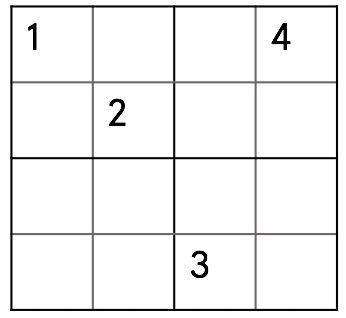

In [ ]:
# Create an empty CP model:

# Create a list (or a dictionary) of the domains of the variables:
# Hint: it's simpler with a dictionary. Handle first the cases of one-value domain
# since there are just a few of them, and then handle the rest in a loop.

# Create the variables:
# Hint: create a two-dimensional list so that 
# every variable can be accessed by its two-dimensional index.
width = 4
cells = []
for i in range(width):
    cells.append([])
    for j in range(width):
        # Create you variable here and append the result to cells[i]:


# Add alldifferent constraints:

# Create a solver:

# Call the solver to find a solution:

# Print out the found solution:

Congratulations! You now know how to write a program solving sudoku.